## Eigenfunction Shapes

This script is designed to determine whether there are any similarites in the shapes of the eigenfunctions for our Cross-in-Plane geometry as $N\rightarrow\infty$ and with $\alpha\in(0,\infty)$.

We will need to:
- Import our eigenvalues and eigenfunctions
- Determine which e'vals and e'funcs correspond lie in the "first band"
- Determine a method for comparing the "shapes" of the eigenfunctions

In [1]:
from fenics import *
from dolfin import *

import numpy as np

import scipy.sparse as spSparse
import scipy.sparse.linalg as spla

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

import glob
import subprocess

# This is the name of our mesh files, minus the extension.
filePrefix = 'FEM_CrossGraphSetup'
# This is the gmsh file which generated our domain's mesh. We can infer information about our domain from it
gmshFile = filePrefix + '.geo'
# This is the folder into which we will place our stiffness matrices, once they are assembled
matDumpFolder = 'StiffnessMatrixDump'
evalDumpFolder = 'EvalDump'
meshDumpFolder = 'MeshDump'

def DeduceN(gFile, line=11):
    '''
    Deduce value of N from the .geo file gFile.
    Optionally, provide the index of the line where this definition appears, 
    default search will be on line 12 (index 11) as per the established convention.
    '''
    with open('FEM_CrossGraphSetup.geo') as fp:
        for i, line in enumerate(fp):
            if i == 11:
                # 11th line
                Nstr = line[4:-2] #take all characters after the numerical value appears in the file
            elif i > 11:
                #terminate loop early
                break
    # We want N as a float because we will use it in computations, to define points on meshes etc. 
    # Int might cause bugs.
    for i, char in enumerate(Nstr):
        if char==';':
            Nstr = Nstr[:i]
            break
    N = float(Nstr)
    return N, Nstr

def FigWindowSettings(axis):
    '''
    Changes a matplotlib.pyplot axis object to have no top and right border or tick marks.
    INPUTS:
        axis: matplotlib.pyplot axis object
    '''

    # Hide the right and top spines
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axis.yaxis.set_ticks_position('left')
    axis.xaxis.set_ticks_position('bottom')
    return

def PlotFunction(N, u, w):

    # Mesh files are saved in the meshDumpFolder with the naming convention
    # Mesh-Nx.xml, where x is replaced by the parameter value of N.
    meshFile = './' + meshDumpFolder + '/Mesh-N' + str(N) + '.xml'
    mesh = Mesh(meshFile)
    print('Loaded meshfile %s' % (meshFile))

    V = FunctionSpace(mesh, 'CG', 1, constrained_domain=CreatePeriodicDomain(N))
    U = Function(V)
    U.vector()[:] = u

    fig, ax = plt.subplots(1)
    FigWindowSettings(ax)
    plot(U)
    fig.colorbar(plot(U))
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r'$N = %d, \ \omega= %.5f $' % (N, w))
    
    return fig, ax

### Periodic Subdomain Classes

Because we are going to be working with multiple domains, we need to be able to specify the parameter $N$ for each of them individually, and thus we need a `PeriodicDomain` subclass for each value of $N$ we plan to use.
As such, we now have the following function which, for a given `N`, returns the appropriate contrained subdomain class for the domain with parameter $N$, so that the mesh is loaded and periodic edges are identified correctly.

This differs from previous scripts because the value of $N$ was manually changed each time a new mesh was to be imported, which we adequate since we only ever dealt with a single mesh at any given time.

In [2]:
def CreatePeriodicDomain(N):
    # Create a subclass for the 2D-periodic domain...
    class PeriodicDomain(SubDomain):
        #map left--> right and bottom-->top
        
        def inside(self, x, on_boundary):
            # return True if on left or bottom boundary AND NOT on one of the two corners
            return bool((near(x[0], 0) or near(x[1], 0)) and
                    (not ((near(x[0], 0) and near(x[1], N)) or
                            (near(x[0], N) and near(x[1], 0)))) and on_boundary)

        def map(self, x, y):
            if near(x[0], N) and near(x[1], N):
                y[0] = x[0] - N
                y[1] = x[1] - N
            elif near(x[0], N):
                y[0] = x[0] - N
                y[1] = x[1]
            else:   # near(x[1], N)
                y[0] = x[0]
                y[1] = x[1] - N
    #concludes the SubDomain subclass definition, now return the subclass...?
    return PeriodicDomain()

### Import Data Files

We now begin to import any data (eigenvalues and eigenvectors) that we have determined and saved to the relevant folders.
It may be the case that there are multiple files for a given value of $N$, depending on whether or not we computed a greater number of eigenvalues and eigenvectors in a given run.
As a temporary default, we will always import the data from the file that contains the _greatest_ number of eigenvalues.

Filenames are stored under the convention
- `evals-Nxx-yyy.npy` for eigenvalues, where `xx` is replaced by the value of $N$ used in that run, and `yyy` is the number of eigenvalues computed.
- `evecs-Nxx-yyy.npy` for eigenvectors, with the same meanings of `xx` and `yyy` as above.
From this, we can always infer how many eigenvalues (and vectors) we are going to import from each file, so can get python to import the correct file.

The outputs are saved to a `dict` called `files`, whose keys are the parameter values of $N$.
Each field is then a list of three objects, `[nEvals, wVals, wVecs]` where `nEvals` is the number of eigenvalues for that value of $N$ (IE, that key), and `wVals` and `wVecs` are numpy arrays storing the eigenvalues and eigenvectors, respectively.

In [3]:
# Infer filenames storing evals and evecs, as stored in evalDumpFolder
# Each of these files has a name of the form
# evals-Nxx-yyy.npy,
# were xx is replaced by the value of N used, and yyy is the number of e'values the file stores.
# For each value of N, there may be multiple files with eigenvalues, so we want to look at the largest value
# of yyy for each xx.
preAppend = './' + evalDumpFolder + '/evals-'
evalFileMatches = glob.glob(preAppend + '*.npy')
# This is a list of all the candidate files, which we have generated that contain eigenvalues and eigenvectors

params = []
for filename in evalFileMatches:
    breaks = filename.split('-')[1:] 
    # this splits filenames by '-', which should break each filename into 3 parts
    # the first is just preAppend, which we can discard using the [1:] syntax
    # the second part is 'Nxx', and the third is 'yyy.npy', which we can now convert to ints
    breaks[0] = int( breaks[0][1:] )
    # discard the N in 'Nxx', and convert the value to an integer
    breaks[1] = int( breaks[1][:-4])
    # discard the '.npy' in 'yyy.npy' and convert the value to an integer
    params.append(breaks)
    
# params now contains [N, nEvals, i] for each file in evalFileMatches, where i is the index of the file in which
# the parameters N and nEvals were used.
# Now, for each unique N, we find the largest such nEvals, and use THAT file.
params = np.asarray(params)
params = params[params[:,0].argsort()] # sorts the values in params by the 1st column, IE by the value N
Ns = np.unique(params[:,0]) # get the unique values of N
# Create a dictionary, with keys equal to the values of N. 
# Each field is then a list [nEvals, wVals, wVecs] of the loaded information
files = {}
for n in Ns:
    # Get the sub-matrix of params that corresponds to this particular value of N
    posNEvals = params[params[:,0]==n]
    # Now sort this sub-matrix by column 1, IE value of nEvals
    posNEvals = posNEvals[posNEvals[:,1].argsort()]
    # This means that the max. value of nEvals is stored at the bottom of this array, so
    # we know the value of N and nEvals to use, and thus the file to import.
    nEvals = posNEvals[-1,1]
    wVals = np.load(preAppend + 'N' + str(n) + '-' + str(nEvals) + '.npy')
    wVecs = np.load('./' + evalDumpFolder + '/evecs-' + 'N' + str(n) + '-' + str(nEvals) + '.npy')
    files[n] = [nEvals, wVals, wVecs]
    print('Deduced for N=%d, nEvals=%d should be used' % (n, nEvals))

Deduced for N=3, nEvals=286 should be used
Deduced for N=4, nEvals=604 should be used
Deduced for N=5, nEvals=1047 should be used
Deduced for N=6, nEvals=1782 should be used
Deduced for N=7, nEvals=2901 should be used
Deduced for N=8, nEvals=2196 should be used
Deduced for N=9, nEvals=2922 should be used
Deduced for N=10, nEvals=2159 should be used
Deduced for N=11, nEvals=2681 should be used
Deduced for N=12, nEvals=3710 should be used


Now we will quickly produce a scatter plot of the imported eigenvalues.

/home/will/anaconda3/envs/fenicsproject/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


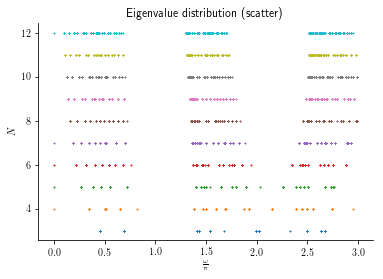

In [4]:
# Now we have all the eigenvalues imported, we can plot each spectrum on the same graph
# to see how the eigenvalues change as N increases
# Note: this cut-off value is set manually, so will need to change depending on the geometry!
fig, ax = plt.subplots(1)
FigWindowSettings(ax)
wCutOff = 3.0 * np.pi
for key in files.keys():
    wVals = files[key][1]
    ax.scatter(wVals[wVals <= wCutOff] / np.pi, key * np.ones_like(wVals[wVals <= wCutOff]), \
               label = str(key), marker='x', s=1)
ax.set_xlabel(r'$\frac{\omega}{\pi}$')
ax.set_ylabel(r'$N$')
ax.set_title(r'Eigenvalue distribution (scatter)')
fig.show()

### Number of found e'values and e'functions

We now want to focus our attention to the first band and the eigenfunctions that lie within.
We expect $N^2$ eigenvalues in this band (for each $N$), however one of these is the 0 eigenvalue so we should also remove this, providing $N^2-1$ interesting eigenfunctions.

We also need to know the $(x,y)$-coordinates of the mesh points used in each run, in order to compare the shapes of the eigenfunctions.

In [5]:
wBandCap = np.pi #this is the observed "safe-cut off" from the scatter plots above
tol = 1e-6 #anything less than this is considered to be zero by us

# this dict will store first band info - keys are values of N, field are lists with entries
# entry 0 is wVals, entry 1 is wVecs, entry 2 is the meshfile name, so we can load and get the coordinates
firstBands = {}
for N in list(files.keys()):
    wVals = files[N][1]
    wVecs = files[N][2]
    
    # first, take the eigenvalues and corresponding functions that lie in the first band
    wVecs = wVecs[:, wVals <= wBandCap]
    wVals = wVals[wVals <= wBandCap]
    wVecs = wVecs[:, wVals > tol]
    wVals = wVals[wVals > tol]
    # we can quickly check that we matched our expectations and found N^2-1 eigenvalues
    if wVals.shape[0]!=(N*N-1):
        print('Warning! N=%d only found %d eigenvalues in first band (expected %d)'% (N, wVals.shape[0], N*N-1))

        # now that we have the e'vals and e'vecs, we need the mesh co-ordinates...
    meshFile = './' + meshDumpFolder + '/Mesh-N' + str(N) + '.xml'
    
    firstBands[N] = [wVals, wVecs, meshFile]

### Helpful Functions

Next we define some functions which will speed up the process of transforming one mesh into another.
The key function for this process is `TransformMesh(meshCoords, N, targetN)` which takes in the mesh-vertex coordinates of the domain with $N=$ `N`, and returns the coordinates of the points that those vertices are mapped to in the domain with $N=$`targetN`.

#### `GetDomainParams(N, alpha=2.0)`

Given the parameters $N$ and $\alpha$ for the domain as illustrated below, compute the tube width $l$ and circle radius $r$.
![./images/Diagram_ThinStructurePeriodCell.png](./images/Diagram_ThinStructurePeriodCell.png)
This is done via the formulae
$$ l = \frac{1}{2N}, \qquad r = \sqrt{\frac{l\alpha}{\pi}}. $$

In [6]:
# for the time being, experiment on a single cell
def GetDomainParams(N, alpha=2.):
    '''
    Given the parameters N and alpha, compute the domain parameters 
    l (tube width) 
    r (circle radius)
    INPUTS:
        N: int; domain parameter N
        alpha: float (default 2.0); scaling parameter alpha for V_vert / V_edge
    OUTPUTS:
        params: (2,) numpy array, containing the parameters [l,r] in that order.
    '''
    
    l = 1.0 / (2.0*N) #tube widths
    r = np.sqrt( l * alpha / np.pi ) #circle radii
    return np.array([l, r])    

#### `GetUnitCell(meshCoords, centre, cellSize)`

Given an array of mesh coordinates (stored row-wise), extract those coordinates which reside in the period cell of the mesh, centred on `centre` and with extent `cellSize` in $x$ and $y$.

The name `GetUnitCell` is slightly misleading, as this function simply extracts a region of _any_ domain, retaining those points $(x,y)$ which lie in the rectangle of dimensions `cellSize[0]`$\times$`cellSize[1]`, with centre at `centre`.
This is due to the function being generalised for later use after deciding upon the original name and purpose.

The first input `meshCoords` is intended to be a `(n,2)` numpy array with $(x,y)$ coordinates stored along the rows, however it can be a general `(n,m)` array, for `m`$\geq2$.
If this case, the function preserves entire rows, but doesn't make use of the additional entries beyond index 1 (column 2).
This is helpful if one is passing in a triple `xyf` which row-wise stores values $(x,y,f(x,y))$, as one can retain the function values at the relevant points whilst "cropping" the domain.

In [7]:
def GetUnitCell(meshCoords, centre=np.array([0.5,0.5]), cellSize=np.array([1.0,1.0])):
    '''
    Get the coordinates within meshCoords that lie in unit cell centred at centre, and extent CellSize
    INPUTS:
        meshCoords: (nVert, xy) float numpy array; x and y coordinates of the vertices are stored row-wise.
            If the dimension xy >= 2, rows will still be preserved, but column indices 0 and 1 will be assumed to be
            (x,y) coordinates.
        centre: (2,) float numpy array; centre of the period cell we want to extract
        cellSize: (2,) float numpy array; widths (x then y) of the period cell
    OUTPUTS:
        cellCoords: (nCellVert, xy) float numpy array; array of x,y coordinates of vertices within desired unit cell
    '''
    
    cellCoords = meshCoords[np.abs(meshCoords[:,0] - centre[0]) <= cellSize[0]/2.0, :]
    cellCoords = cellCoords[np.abs(cellCoords[:,1] - centre[1]) <= cellSize[1]/2.0, :]
    return cellCoords

#### `NearBoundary(xy, N, boundaryTol)`

Given a point `xy`, determine whether this point is within `boundaryTol` of the boundary of the domain with $N$ period cells.

The function will return the following values (in the order provided) in a 3-tuple:
1. A boolian `True`/`False` value depending on whether the point `xy`lies within a distance `boundaryTol` of the domain boundary or not (respectively)
2. A character (length 1 string) detailing which part of the boundary the point is close to; possibilities are
    - `'c'` : when `xy` is close to the circular part of the boundary
    - `'v'` : when `xy` is close to a vertical tube boundary
    - `'h'` : when `xy` is close to a horizontal tube boundary
3. The distance from `xy` to the closest boundary

In [8]:
def NearBoundary(xy, N, boundaryTol = 1e-8):
    '''
    Check if the given point xy is near to the boundary of the domain N, to within the specified tolerance.
    INPUTS:
        xy: (2,) numpy array; coordinate to check
        N: int; domain parameter N
        boundaryTol: float (default 1e-8); tolerance to which "near to boundary" is accepted
    OUTPUTS:
        tf: bool; True if xy was within boundaryTol of the domain boundary, otherwise False
        boundary: character; describes the portion of the boundary that xy was close to.
            - 'c' : circle
            - 'v' : vertical tube boundary
            - 'h' : horizontal tube boundary
            - 'n' : returned if tf is False
        prox: float; distance of point to boundary
    '''

    paramsN = GetDomainParams(N)
    # for ease, translate xy to the cell centred on 0
    cellX = np.floor(xy[0])
    cellY = np.floor(xy[1])
    xyTest = xy - np.array([cellX + 0.5, cellY + 0.5])
    #print('Moved', xy, 'to', xyTest)
    
    if ( (xyTest[0]**2 + xyTest[1]**2) - paramsN[1]**2 <= boundaryTol ):
        # this point is near the circle boundary
        return True, 'c', (xyTest[0]**2 + xyTest[1]**2) - paramsN[1]**2
    elif ( np.abs( xyTest[0] - paramsN[0] ) <= boundaryTol ):
        # this point is near the vertical boundary
        return True, 'v', np.abs( xyTest[0] - paramsN[0] )
    elif ( np.abs( xyTest[1] - paramsN[0] ) <= boundaryTol) :
        # this point is near the horizontal boundary
        return True, 'h', np.abs( xyTest[1] - paramsN[0] )
    else:
        # if we get to here, this point _really_ isn't near the boundary
        #print('----- CaseError: (%.3f, %.3f)' % (xyTest[0], xyTest[1]))
        #print('x^2 + y^2 - r^2 = %e is false' % (xyTest[0]**2 + xyTest[1]**2 - paramsN[1]**2))
        #print('Tube width: %.3f does not fit either co-ordinate' % (paramsN[0]))
        prox = np.array([np.abs( xyTest[0]**2 + xyTest[1]**2 - paramsN[1]**2), \
                         np.abs( xyTest[0] - paramsN[0] ), \
                         np.abs( xyTest[1] - paramsN[0] )])
        return False, 'n', np.min(prox)

#### `TransformPoint(xy, N, targetN, boundaryTol)`

Given a point `xy` which lies in a unit cell centred on $O = (0,0)$ in the domain with parameter $N=$`N`, map `xy` to the domain with parameter $N=$`targetN`.

Let $\Omega_{\mathrm{N}}$ denote the domain with parameter $N=$`N`, and $\Omega_{\mathrm{targetN}}$ the domain with parameter $N=$`targetN`.
Consider the unit cells of $\Omega_{\mathrm{N}}$ and $\Omega_{\mathrm{targetN}}$ being centred on $O$; denote them by $P_{\mathrm{N}}$ and $P_{\mathrm{targetN}}$ respectively, the tubes and circles in each unit cell can then be thought of as enlargements (centred on $O$) of each other.
We can then use these enlargements to translate a point `xy` within $P_{\mathrm{N}}$ to it's corresponding position within the unit cell of $P_{\mathrm{targetN}}$.
It is this mapping which `TransformPoint(xy, N, targetN, boundaryTol)` performs, which is illustrated below.

![Transforms of the unit cell](./images/DomainCellTransforms.png)

Points within the "circular part" of $P_{\mathrm{N}}$ retain their argument (angle from the positive $x$-axis) and have their amplitudes scaled by the ratio $\frac{r_{\mathrm{targetN}}}{r_{\mathrm{N}}}$.
Points within the "vertical tubes" of $P_{\mathrm{N}}$ scale as below:
- The $x$-coordinate of these points is scaled by $\frac{l_{\mathrm{targetN}}}{l_{\mathrm{N}}}$, denote this new value by $x'$.
- Given the $y$-coordinate `xy[1]` $>0$, let $d$ be the length of the vertical line which connects the point $($ `xy[0]` $,0.5)$ (on the top boundary of the period cell) to the nearest point on the circumfrence of the circle with $x$-coordinate `xy[0]`. Let $d'$ be the analogue of $d$ in $P_{\mathrm{targetN}}$ for $x$-coordinate equal to $x'$. The new $y$-coordinate, $y'$, is then computed by $y'= \frac{d'}{d}$ `xy[1]`. That is, the "proportion of the distance into the tube" that `xy[1]` corresponds to is preserved.
- Given the $y$-coordinate `xy[1]` $<0$, perform the same process as above but using points on the bottom boundary and lower part of the circumfrence of the circle.
Points within the "horizontal tubes" of $P_{\mathrm{N}}$ scale in the same was as those in the vertical tubes, but interchanging the roles of the $x$ and $y$ coordinates.

In [9]:
def TransformPoint(xy, N, targetN, boundaryTol = 1e-8):
    '''
    Given a point xy in a unit cell centred on (0,0) in the domain with parameter N,
    map xy to the corresponding point in the domain of parameter targetN according to our domain transform.
    Note that we assume that the unit cell has unit length in the x and y directions.
    INPUTS:
        xy: (2,) float numpy array; x,y coordinates of point in domain N
        N: int; parameter N of the domain in which the point xy lies
        targetN: int; paramter N of the domin into which this point is to be mapped
        boundaryTol: float; tolerance to which points outside the domain boundary are considered "on" the boundary
    OUTPUTS:
        transform: (2,) float numpy array; x,y coordinates of the image of xy under the domain transform
    '''
    
    # catch no-work case
    if N==targetN:
        return xy
    
    transform = np.zeros((2), dtype=float)
    paramsN = GetDomainParams(N)
    paramsTarget = GetDomainParams(targetN)
    ratios = paramsTarget / paramsN
    
    if ((xy[0]**2 + xy[1]**2) <= paramsN[1]**2):
        # if this point lies in the circle, we need to shrink by a scale factor
        transform[0:2] = xy * ratios[1]

    elif (np.abs( xy[0] ) <= paramsN[0]):
        # this point lies in the vertical tube
        # horizontal width, thus x-coord, shrinks according to length ratio
        transform[0] = xy[0] * ratios[0]
        # y-coord scales with tube-length though
        tubeFibreLength = 0.5 - np.sqrt(paramsN[1]**2 - xy[0]**2)
        targetTubeFibreLength = 0.5 - np.sqrt(paramsTarget[1]**2 - transform[0]**2)
        if (xy[1] >= 0):
            # in upper tube (as we assume cell centred on (0,0))
            yProp = (0.5 - xy[1]) / tubeFibreLength
            transform[1] = 0.5 - yProp*targetTubeFibreLength
        else:
            # we must be in the lower tube
            yProp = (0.5 + xy[1]) / tubeFibreLength
            transform[1] = -0.5 + yProp*targetTubeFibreLength

    elif (np.abs( xy[1] ) <= paramsN[0]):
        # this points lies in the horizontal tube
        # vertical width, thus y-coord, shrinks according to length ratio
        transform[1] = xy[1] * ratios[0]
        # x-coord scales with tube-length though
        tubeFibreLength = 0.5 - np.sqrt(paramsN[1]**2 - xy[1]**2)
        targetTubeFibreLength = 0.5 - np.sqrt(paramsTarget[1]**2 - transform[1]**2)
        if (xy[0] >= 0):
            # in right tube
            xProp = (0.5 - xy[0]) / tubeFibreLength
            transform[0] = 0.5 - xProp*targetTubeFibreLength
        else:
            #we must be in the left tube
            xProp = (0.5 + xy[0]) / tubeFibreLength
            transform[0] = -0.5 + xProp*targetTubeFibreLength

    else:
        # if we get to here, we either have a spurious point emerging in our domain,
        # or numerical inaccuracy has placed us just outside our domain.
        # as such, we check for "near boundary" cases
        if ( (xy[0]**2 + xy[1]**2) - paramsN[1]**2 <= boundaryTol ):
            # this point is on the boundary of the circle, numerical error places it outside though
            # move it back onto the boundary and transform as per a circle point
            angle = np.angle(xy[0] + 1j * xy[1])
            boundaryPt = np.array([paramsN[1] * np.cos(angle), paramsN[1] * np.sin(angle)])
            transform[0:2] = boundaryPt * ratios[1]
        elif ( np.abs( xy[0] - paramsN[0] ) <= boundaryTol ):
            # this point is on the vertical boundary, numerical error placing it outside
            # move back to boundary and transform as if it were on the vertical boundary
            boundaryPt = np.array([np.sign(xy[0]) * paramsN[0], xy[1]])
            transform[0] = boundaryPt[0] * ratios[0]
            # y-coord scales with tube-length though
            tubeFibreLength = 0.5 - np.sqrt(paramsN[1]**2 - boundaryPt[0]**2)
            targetTubeFibreLength = 0.5 - np.sqrt(paramsTarget[1]**2 - transform[0]**2)
            if (xy[1] >= 0):
                # in upper tube (as we assume cell centred on (0,0))
                yProp = (0.5 - xy[1]) / tubeFibreLength
                transform[1] = 0.5 - yProp*targetTubeFibreLength
            else:
                # we must be in the lower tube
                yProp = (0.5 + xy[1]) / tubeFibreLength
                transform[1] = -0.5 + yProp*targetTubeFibreLength
        elif ( np.abs( xy[1] - paramsN[0] ) <= boundaryTol) :
            # this points is on the horizontal boundary, numerical error placing it outside
            # move back to boundary and transform as if it were on the horizontal boundary
            boundaryPt = np.array([xy[0], np.sign(xy[1]) * paramsN[0]])
            transform[1] = boundaryPt[1] * ratios[0]
            # x-coord scales with tube-length though
            tubeFibreLength = 0.5 - np.sqrt(paramsN[1]**2 - boundaryPt[1]**2)
            targetTubeFibreLength = 0.5 - np.sqrt(paramsTarget[1]**2 - transform[1]**2)
            if (xy[0] >= 0):
                # in right tube
                xProp = (0.5 - xy[0]) / tubeFibreLength
                transform[0] = 0.5 - xProp*targetTubeFibreLength
            else:
                #we must be in the left tube
                xProp = (0.5 + xy[0]) / tubeFibreLength
                transform[0] = -0.5 + xProp*targetTubeFibreLength
        else:
            # if we get to here, this point _really_ isn't just outside the boundary, 
            # nor is it in the domain. Spit out an error
            print('----- CaseError: (%.3f, %.3f)' % (xy[0], xy[1]))
            print('x^2 + y^2 - r^2 = %e is false' % (xy[0]**2 + xy[1]**2 - paramsN[1]**2))
            print('Tube width: %.3f does not fit either co-ordinate' % (paramsN[0]))
            raise ValueError('Could not fit point (%.3f, %.3f), to case' % (xy[0], xy[1]) )
    
    return transform

#### `TransformMesh(meshCoords, N, targetN)`

Given an array of coordinates `meshCoords` (stored row-wise) corresponding to points in the domain $\Omega_{\mathrm{N}}$, compute the transforms of these points into the domain $\Omega_{\mathrm{targetN}}$, returning an array of the same shape as `meshCoords`.

`TransformMesh` just calls `TransformPoint` on each coordinate provided in `meshCoords`, so is not vectorised and thus may take a long time for large meshes or large numbers of points.
`TransformMesh` can deal with points outside the unit cell that `TransformPoints` requires though - each point will be automatically translated into the correct unit cell, tranformed via `TransformPoints`, and then translated back to the correct position in the domain.

`meshCoords` can be of shape`(n,m)` for `m` $\geq2$ rather than the expected `(n,2)`, in which case the first two columns are interpretted as the $x$ and $y$ coordinates of the points, and the remaining columns are ignored.
This is the same behaviour as in `GetUnitCell`.

In [10]:
def TransformMesh(meshCoords, N, targetN):
    '''
    Given a set of points meshCoords containing vertices of a mesh of the domain with parameter N,
    transform these points onto the domain with parameter targetN, using appropriate scalings.
    Note that we assume that the unit cell has unit length in the x and y directions.
    INPUTS:
        xy: (nVert, 2) float numpy array; x,y coordinates of point in domain N stored row-wise
        N: int; parameter N of the domain in which the point xy lies
        targetN: int; paramter N of the domin into which this point is to be mapped
    OUTPUTS:
        transform: (2,) float numpy array; x,y coordinates of the image of xy under the domain transform
    '''
    
    transformedMesh = np.zeros_like(meshCoords)
    
    for j, xy in enumerate(meshCoords):
        # in order to use TransformPoint, we first need to translate the point xy to the position it would take
        # if it's period cell was centred on (0,0).
        # To do so, we just need to determine how many ``cells along" in the x and y directions this point is
        cellX = np.floor(xy[0])
        cellY = np.floor(xy[1])
        # (cellX, cellY) is the bottom-left corner of the unit cell in which xy lies
        # we need to translate it by -1 * [cellX + 0.5, cellY + 0.5], the 0.5's ensuring centering on (0,0)
        translation = [cellX + 0.5, cellY + 0.5]
        unitCellXY = xy - translation
        transformedMesh[j,:] = TransformPoint(unitCellXY, N, targetN) + translation
        
    return transformedMesh

#### `VisualTransformTest(N, targetN)`

Given the vertex coordinates of the mesh of $\Omega_{\mathrm{N}}$, compute the transform of these meshpoints into the domain $\Omega_{\mathrm{targetN}}$ and then plot (in the order given):
1. The original mesh points
2. The transformed mesh points
3. The mesh points of the target domain

Plots are also labelled with "Before", "Transform", and "Target" for the plots 1 through 3 respectively.
Plots are also automatically cropped to only plot to the extent of the target domain $\Omega_{\mathrm{targetN}}$.

The main purpose of this function is a visual confirmation that mesh points are being transformed in a consistent manner.

In [11]:
def VisualTransformTest(N, targetN):
    '''
    Plots the transformed vertex points of the mesh of the domain with parameter N when scaled to the domain
    of paramter targetN
    '''
    meshFile = './' + meshDumpFolder + '/Mesh-N' + str(N) + '.xml'
    mesh = Mesh(meshFile)
    coords = mesh.coordinates()
    meshFileTarget = './' + meshDumpFolder + '/Mesh-N' + str(targetN) + '.xml'
    meshTarget = Mesh(meshFileTarget)
    coordsTarget = meshTarget.coordinates()

    transform = TransformMesh(coords, N, targetN)

    fig, ax = plt.subplots(1)
    FigWindowSettings(ax)
    ax.scatter(coords[:,0], coords[:,1], np.ones_like(coords[:,0]))
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_xlim(0,targetN)
    ax.set_ylim(0,targetN)
    ax.set_title(r'Before (cropped/expanded domain)')
    plt.show()

    fig, ax = plt.subplots(1)
    FigWindowSettings(ax)
    ax.scatter(transform[:,0], transform[:,1], np.ones_like(transform[:,0]))
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_xlim(0,targetN)
    ax.set_ylim(0,targetN)
    ax.set_title(r'Transform (cropped/expanded domain)')
    plt.show()

    fig, ax = plt.subplots(1)
    FigWindowSettings(ax)
    ax.scatter(coordsTarget[:,0], coordsTarget[:,1], np.ones_like(coordsTarget[:,0]))
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_xlim(0,targetN)
    ax.set_ylim(0,targetN)
    ax.set_title(r'Target domain')
    plt.show()
    
    return

#### `FuncOnNewMesh(f, N, targetN, targetOnTop)`

Determine the transform of the vertex coordinates of the mesh of the domain $\Omega_{\mathrm{targetN}}$.
Then, compute the values of the given function function `f` defined on $\Omega_{\mathrm{N}}$ at thesse transformed coordinates.
Return an array of triples `x,y,f(x,y)` where `x,y` are coordinate pairs in $\Omega_{\mathrm{N}}$ arising from the mesh of $\Omega_{\mathrm{N}}$ and the transform of the points in $\Omega_{\mathrm{targetN}}$, and `f(x,y)` the function value at the point `x,y`.

Let $f$ be a (eigen)function defined on $\Omega_{\mathrm{N}}$.
$f$ is represented by a finite vector `f`, which can be assembled via `FunctionSpace` and `Function` to evaluate the function $f$ at points within the domain $\Omega_{\mathrm{N}}$.
In particular, we can evaluate $f$ at the vertex (or mesh) coordinates $M_{\mathrm{N}}$.
Next, we can load the mesh coordinates $M_{\mathrm{targetN}}$ of $\Omega_{\mathrm{targetN}}$ and transform these into $\Omega_{\mathrm{N}}$.

At this point it is necessary to "crop" the larger of the two domains:
 - Case $\mathrm{N}\leq\mathrm{targetN}$: The centre of $\Omega_{\mathrm{N}}$ is associated to the centre of $\Omega_{\mathrm{targetN}}$, and $\Omega_{\mathrm{targetN}}$ is then cropped by removing any points that do not fall within the square $$\left[\frac{\mathrm{targetN}}{2} - \frac{\mathrm{N}}{2}, \frac{\mathrm{targetN}}{2} + \frac{\mathrm{N}}{2}\right]^2. $$
 - Case $\mathrm{N}\geq\mathrm{targetN}$: Similar to the above, but with roles reversed. In this case, it is necessary to transform _all_ coordinates in $M_{\mathrm{targetN}}$ rather than a subset, as in the previous case.
Having cropped and made this association, the relevant points in $M_{\mathrm{targetN}}$ are then mapped into $\tilde{M}_{\mathrm{targetN}}\subset\Omega_{\mathrm{N}}$.
We then evaluate $f$ at each of the coordinates in $\tilde{M}_{\mathrm{targetN}}$.

This allows us to then assemble an array of triples $(x,y,z)$ where
- $(x,y)\in M_{\mathrm{N}}\cup\tilde{M}_{\mathrm{targetN}}$. The order in which the points appear is identical to the order they appear in $M_{\mathrm{N}}$ and $\tilde{M}_{\mathrm{targetN}}$, with one set "stacked on top of" the other. The variable `targetOnTop` changes whether points in $\tilde{M}_{\mathrm{targetN}}$ are listed first or not.
- $z$ is the function value $f(x,y)$.


In [12]:
def FuncOnNewMesh(f, N, targetN, targetOnTop=False):
    '''
    Given a function f defined on the domain N, determine the transform of the points in the domain targetN into
    the domain N.
    Then, evaluate the function f at these new points, returning an array of (x,y,f(x,y)) containing the coordinates
    (x,y) of all the points (in domain N) that f was evaluated at, and the function values there.
    INPUTS:
        f: (n,) numpy array; vertex-values of Function object
        N: int; domain parameter for the function f
        targetN: int; domain parameter from which extra coordinates will be transformed
        targetOnTop: bool (default False); if True, then the output will have the transformed triples (coords from
        the domain targetN) stacked above the original triples from the domain N. False is the reverse.
    OUTPUTS:
        xyf: (nn, 3) numpy array; index 0 is x-coord, index 1 is y-coord, and index 2 is function value at (x,y)
    '''
    
    # load mesh and function space for domain N
    meshN = Mesh('./' + meshDumpFolder + '/Mesh-N' + str(N) + '.xml')
    coordsN = meshN.coordinates()
    VN = FunctionSpace(meshN, 'CG', 1, constrained_domain=CreatePeriodicDomain(N))
    UN = Function(VN)
    UN.vector()[:] = f
    # this will allow for evalutation of f outside the domain, however we know that worst case our
    # transform maps the boundary to the boundary, so we allow this option to avoid throwing up errors when
    # we want to evaluate a point that appears "outside" the domain even though it's actually on the boundary
    # Of course, we should CHECK that any such points are close to the boundary before we do this!
    UN.set_allow_extrapolation(True)
    # compute values of f at vertices of meshN
    fMeshNVals = UN.compute_vertex_values(meshN)
    xyfN = np.append(coordsN, fMeshNVals[:,None], axis=1)  
    
    if N==targetN:
        # if we get to here, then N=targetN... so there's nothing to do, the meshes are the same!
        print('N (%d) = targetN (%d), nothing to do.' % (N, targetN))
        return xyfN

    # load mesh and coords for domain targetN
    meshTarget = Mesh('./' + meshDumpFolder + '/Mesh-N' + str(targetN) + '.xml')
    coordsTarget = meshTarget.coordinates()
   
    # now, transform the mesh of domain targetN to the mesh of domain N
    # we must consider which domain is "smaller" and so needs to be translated here
    if N < targetN:
        # if N < targetN means we only want to take the central N period cells of domain targetN,
        # translate their coordinates into domain N, then evaluate f at them
        croppedCoords = GetUnitCell(coordsTarget, \
                                    centre = np.array([targetN/2.0,targetN/2.0]), \
                                    cellSize = np.array([N,N], dtype=float))
        # now translate the relevant coordinates
        tCoordsTarget = TransformMesh(croppedCoords, targetN, N)
        # these coords are in the range [targetN/2 - N/2, targetN/2 + N/2], but we need them in the range [0, N]
        # thus, we need to translate...
        translation = np.array([targetN/2.0 - N/2, targetN/2.0 - N/2])
        tCoordsTarget -= translation
    else:
        # we have N > targetN, we need to discard some of our original xyfN triples.
        # it also means that the targetN mesh needs to be translated to the "centre" of the domain N mesh
        # first, discard points "outside" the centre
        xyfN = GetUnitCell(xyfN, \
                           centre = np.array([N/2.0, N/2.0]), \
                           cellSize = np.array([targetN, targetN], dtype=float))
        # get unit cell should crop correctly even though this is a (n,3) array - 
        # it should only look at the first 2 indices when deciding what to crop out
        tCoordsTarget = TransformMesh(coordsTarget, targetN, N)
        # these coords are in the range [0, targetN] but we need them in the 
        # range [N/2 - targetN/2, N/2 + targetN/2]
        translation = np.array([N/2.0 - targetN/2.0, N/2.0 - targetN/2.0])
        tCoordsTarget += translation #this one is a positive translation, unlike above case
   
    # we can now evaluate f at each coordinate in tCoordsTarget
    fTargetN = np.zeros_like(tCoordsTarget[:,0], dtype=float)
    for i, xy in enumerate(tCoordsTarget):
        try:
            UN.eval(fTargetN[i:(i+1)], xy) #dolfin eval method is NOT vectorised!
        except RuntimeError:
            # dolfin complains that the point is not within the domain... is it's concern justified?
            tf, b = NearBoundary(xy, N, boundaryTol=1e-3)
            if tf:
                # this point is close to the boundary, just extrapolate
                UN.set_allow_extrapolation(True)
                UN.eval(fTargetN[i:(i+1)], xy)
                UN.set_allow_extrapolation(False)
            else:
                raise RuntimeError('Point (%.3f, %.3f) really is not close to the boundary!' % (xy[0], xy[1]))
    xyfTargetN = np.append(tCoordsTarget, fTargetN[:,None], axis=1)
    # xyfTargetN and xyfN now contain triples of (x,y, f(x,y)) coord-pairs in domain N
    
    if targetOnTop:
        # append xyf arrays with the targetN-translated triples on the top
        xyf = np.append(xyfTargetN, xyfN, axis=0)
    else:
        # apped xyf arrays with domain N-triples on top
        xyf = np.append(xyfN, xyfTargetN, axis=0)
    return xyf

## Comparing Eigenfunction Shapes

So we now have a method which allows us to transform one mesh's coordinates onto another.
This means that we can now begin to analyse the shape of eigenfunctions across domains.

Our status is now as follows: we can take two functions $f_{N_1}$ and $f_{N_2}$ from the domains with paramter $N$ equal to $N_1$ and $N_2$ respectively.
These domains have mesh coordinate arrays $M_1$ and $M_2$ respectively, and we know the values of $f_{N_i}$ at $M_i$ for $i=1,2$.
Let $T_{12}$ denote the transform that maps coordinates in the domain $N_1$ to $N_2$, and $T_{21}$ it's inverse.
We now need to compute the values of $f_{N_2}$ at $M_1$, and the values of $f_{N_1}$ at $M_2$, which will require the use of $T_{12}$ and $T_{21}$, as follows:
- Compute $\tilde{M}_2 = T_{12}(M_1)$ and $\tilde{M}_1 = T_{21}(M_2)$.
- Compute $f_{N_1}$ at $\tilde{M_1}$ and $f_{N_2}$ at $\tilde{M}_2$.
- Let $M^*_1 = M_1 \cup \tilde{M}_1$ and $M^*_2 = M_2 \cup \tilde{M}_2$. Then we have that $T_{12}(M^*_1) = M^*_2$, and $T_{21}(M^*_2) = M^*_1$.
- This means we now have the values of $f_{N_1}$ at $M^*_1$ and $f_{N_2}$ at $M^*_2$.
- WLOG, we can now map the values of $f_{N_1}$ at $M^*_1$ to values at $M^*_2$ via $T_{12}$. The result is that we now have function values of $f_{N_1}$ and $f_{N_2}$ at $M^*_2$, and so can compare shapes.
- Normalise each of the function values $f_{N_1}$ and $f_{N_2}$.

#### `CompareShapes(xyf1, xyf2)`

Given data for two functions $f_1, f_2$ in the arrays of triples `xyf1, xyf2` respectively, compare the shapes of the two functions and return the result of this similarity metric.

The arrays of triples are `x,y,f(x,y)` where `x,y` are coordinate pairs in the respective domains $\Omega_{\mathrm{N}_1}, \Omega_{\mathrm{N}_2}$ of the functions $f_1, f_2$. 
The value `f(x,y)` is the (respective) function value at the point `x,y`.

It is assumed from the input that the coordinate pairs match (under the transforms $T_{12}$ and $T_{21}$) pairwise, namely that `xyf1[i,0:2]` is the image of `xyf2[i,0:2]` in $\Omega_{\mathrm{N}_1}$.
This means that the function values in the 3rd column can be assumed to be the values of the two functions $f_1$ and $f_2$ at the same selection of points.
If there are concerns that this might not be adhered to, one can run `CoordMatchCheck` to filter out any points which do not appear to be the result of such a mapping.

Currently, the metric for comparing the two shapes is to normalise both functions by their maximum (in absolute) value, and then take an $L^1$-norm approximation by summing the pointwise difference of each function.

In [13]:
def CompareShapes(xyf1, xyf2):
    '''
    Given data for two functions f1, f2 in arrays of triples xyf1,xyf2 respectively, 
    compare the shapes of these functions.
    INPUTS:
        xyf1, xyf2: (n,3) numpy array; x,y,f(x,y) triples for the functions f1 and f2 respectively
    OUTPUTS:
        compVal: float; metric value for similarity of function shapes
        xyfDiff: (n,) numpy array; pointwise difference of function values, ordered as in xyf1 and xyf2
    '''
    # normalise and then compare values
    xyfDiff = ( xyf1[:,2] / np.max(np.abs(xyf1[:,2])) ) - ( xyf2[:,2] / np.max(np.abs(xyf2[:,2])) )
    
    # run the comparison metric
    compVal = np.sum(np.abs(xyfDiff))
    
    return compVal, xyfDiff

#### `CoordMatchCheck(xyf1, xyf2, tol, talkative)`

Given data for two functions $f_1, f_2$ in the arrays of triples `xyf1, xyf2` respectively, check that the coordinate pairs match across the two arrays.

The arrays of triples are `x,y,f(x,y)` where `x,y` are coordinate pairs in the respective domains $\Omega_{\mathrm{N}_1}, \Omega_{\mathrm{N}_2}$ of the functions $f_1, f_2$. 
The value `f(x,y)` is the (respective) function value at the point `x,y`.

It should be the case that the coordinate pairs match (under the transforms $T_{12}$ and $T_{21}$) pairwise, namely that `xyf1[i,0:2]` is the image of `xyf2[i,0:2]` in $\Omega_{\mathrm{N}_1}$.
However, numerical error and "boundary cases" may result in points not following this mapping precisely, which in turn would invalidate the result of shape comparison.

This function manually checks that each point has been mapped in the manner above, to a given tolerance `tol`.
One can ask the function for more information on cases that fail by optionally setting `talkative` to `True`.
Returned are two arrays of triples which contain only those rows in `xyf1` and `xyf2` which transformed correctly (within `tol`), and a list of indices `goodInd` which contains the indices of the rows that were preserved.

In [14]:
def CoordMatchCheck(xyf1, xyf2, tol=1e-8, talkative=False):
    '''
    Given data for two functions f1, f2 in arrays of triples xyf1,xyf2 respectively, 
    check that the coordinate pairs map to each other according to the domain transforms, removing those which don't.
    INPUTS:
        xyf1, xyf2: (n,3) numpy array; x,y,f(x,y) triples for the functions f1 and f2 respectively
        tol: float (default 1e-8); tolerance for accepting a transform as correct
        talkative: bool (default False); if True, then details on failure cases will be printed
    OUTPUTS:
        xyf1Valid, xyf2Valid: (m,3) numpy array; x,y,f(x,y) triples that have correct coordinate transforms
        goodInd: (m) int-list; list of row indices in xyf1/xyf2 that had correct transforms
    '''
    
    goodInd = []
    for i, xy1 in enumerate(xyf1[:,0:2]):
        xy2 = xyf2[i,0:2]
        cell1X = np.floor(xy1[0])
        cell1Y = np.floor(xy1[1])
        cell2X = np.floor(xy2[0])
        cell2Y = np.floor(xy2[1])
        # (cellX, cellY) is the bottom-left corner of the unit cell in which xy lies
        # we need to translate it by -1 * [cellX + 0.5, cellY + 0.5], the 0.5's ensuring centering on (0,0)    
        trans1 = [cell1X + 0.5, cell1Y + 0.5]
        trans2 = [cell2X + 0.5, cell2Y + 0.5]
        xy1UnitCell = xy1 - trans1
        xy2UnitCell = xy2 - trans2
        xy2Theory = TransformPoint(xy1UnitCell, N1, N2, boundaryTol = tol)
        if np.linalg.norm(xy2UnitCell - xy2Theory) <= tol:
            goodInd.append(i)
        elif talkative:
            print('Mismatch: xy2UnitCell (%.5f, %.5f) is %.2e from xy2Theory (%.5f, %.5f)' \
                  % (xy2UnitCell[0], xy2UnitCell[1], np.linalg.norm(xy2UnitCell - xy2Theory), \
                    xy2Theory[0], xy2Theory[1]) )
            print('Whilst attempting to transform:', xy1UnitCell)
    
    xyf1Valid = xyf1[goodInd, :]
    xyf2Valid = xyf2[goodInd, :]
    
    return xyf1Valid, xyf2Valid, goodInd

/home/will/anaconda3/envs/fenicsproject/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


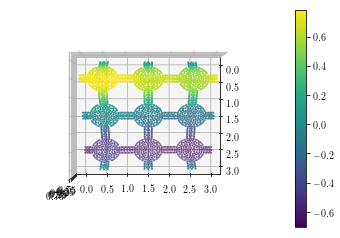

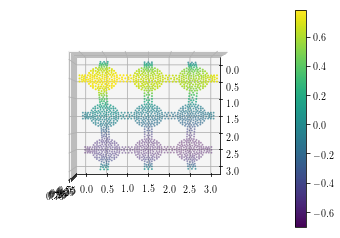

In [15]:
# temporary test values for variables
N = 3
targetN = 5
f = firstBands[N][1][:,1]
mf = firstBands[N][2]


# first, load both meshes and obtain function values at the vertices
mesh = Mesh(mf)
M = mesh.coordinates()
V = FunctionSpace(mesh, 'CG', 1, constrained_domain=CreatePeriodicDomain(N))
U = Function(V)
U.vector()[:] = f
UCoordVals = U.compute_vertex_values(mesh)
xyf = np.append(M, UCoordVals[:,None], axis=1)
q = np.shape(xyf)

xyfPrototype = FuncOnNewMesh(f, N, targetN, targetOnTop=False)

#fig, ax = plt.subplots(1)
#FigWindowSettings(ax)
#ax.scatter(xyfPrototype[0:q[0],0], xyfPrototype[0:q[0],1], xyfPrototype[0:q[0],2])
#ax.scatter(xyfPrototype[q[0]:,0], xyfPrototype[q[0]:,1], xyfPrototype[q[0]:,2])
#ax.set_xlabel(r'$x$')
#ax.set_ylabel(r'$y$')
#plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(xyfPrototype[:,0], xyfPrototype[:,1], xyfPrototype[:,2], c=xyfPrototype[:,2], s=1)
ax.view_init(azim=0, elev=90)
fig.colorbar(p)
fig.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(xyf[:,0], xyf[:,1], xyf[:,2], c=xyf[:,2], s=1)
ax.view_init(azim=0, elev=90)
fig.colorbar(p)
fig.show()

Loaded meshfile ./MeshDump/Mesh-N3.xml
Loaded meshfile ./MeshDump/Mesh-N5.xml
1002.0601129447612


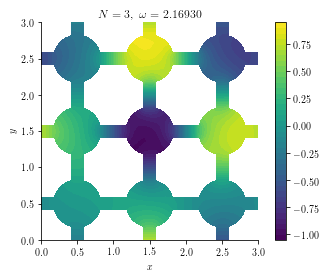

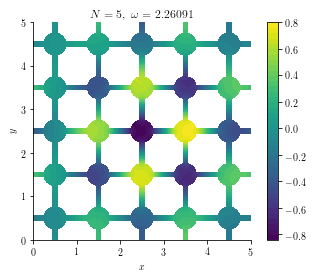

In [16]:
N1 = 3
N2 = 5

# catch even-valued N as haven't decided what to do with those yet...
if N1%2!=1:
    raise ValueError('N1=%d is not odd, ambiguity in centre of domain' % (N1))
elif N2%2!=1: 
    raise ValueError('N2=%d is not odd, ambiguity in centre of domain' % (N2))
    
# test run: compare one of the functions in firstBands[N1] with another in firstBands[N2]
# don't forget to check that the coordinates are the same, so we can directly compare function values!

f1Test = firstBands[N1][1][:,-1]
f2Test = firstBands[N2][1][:,-1]

# function plots to judge result in eyeball norm
fig1, ax1 = PlotFunction(N1, f1Test, firstBands[N1][0][-1])
fig2, ax2 = PlotFunction(N2, f2Test, firstBands[N2][0][-1])

xyf1 = FuncOnNewMesh(f1Test, N1, N2, targetOnTop=False)
xyf2 = FuncOnNewMesh(f2Test, N2, N1, targetOnTop=True) 
# need targetOnTop to be true in one of these so co-ords are stacked in the same order across both

# although xyf1 has (x,y) in N1 and xyf2 has (x,y) in N2, we know that the points transform row-wise into each other
# however, due to some numerical errors near the boundary, we might not have as precise a matching as we would like
# thus, we should filter out any points which as "far away" from each other
xyf1Valid, xyf2Valid, goodInd = CoordMatchCheck(xyf1, xyf2, tol=1e-8)

# having checked, we can form the pointwise difference of the two (normalised!) function values
# and use the L1-norm as a gauge for how similar in shape they are
print( CompareShapes(xyf1Valid, xyf2Valid)[0] )